In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [177]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return x*(1 - x)

class Layer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size                           # 入力数
        self.output_size = output_size                         # ニューロン数と同じ
        self.w = (np.random.rand(output_size, input_size) - 0.5) * 0.1 # ニューロンごとに入力と同数の足がある分の重み
        self.b = (np.random.rand(output_size) - 0.5) * 0.2             # ニューロンごとのしきい値
    
    def h(self, x):
        return sigmoid(x)
    
    def dh(self, x):
        return dsigmoid(x)
    
    def output_neuron(self, W, b, X):
        s = np.sum(W*X)
        y = self.h(s - b)
        return y
    
    def train_neuron(self, W, b, X, t):
        o = self.output_neuron(W, b, X)
        d = -alpha*(t - o)*self.dh(o);
        W -= d*X
        return
    
    def output_layer(self, x):
        y = np.zeros(self.output_size)
        for i in range(self.output_size):
            y[i] = self.output_neuron(self.w[i], self.b[i], x)
        return y

    def train_layer(self, x, t):
        for i in range(self.output_size):
            self.train_neuron(self.w[i], self.b[i], x, t[i])
        return

In [5]:
def smaller(image):
    def seri(x, y):
        return y*28 + x

    simages = np.zeros(14*14)
    for i in range(14):
        for j in range(14):
            x, y = j*2, i*2
            avg = (image[seri(x+0, y+0)] + image[seri(x+0, y+1)] + image[seri(x+1, y+0)] + image[seri(x+1, y+1)])/4.0
            simages[i*14 + j] = avg
    return simages

In [6]:
images, labels = mnist.train.next_batch(10)

In [7]:
print(smaller(images[1]))
print(labels[1])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.03039216  0.37843138  0.49705887  0.28921571  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.39019608  0.86470592  0.96274519  0.89313734  0.93431377  0.22843139
  0.          0.          0.          0.          0.          0.          0.
  0.04019608  0.90490198  0.87352949  0.41666669  0.02941177  0.55784315
  0.59509808  0.          0.          0.          0.          0.          0.
  0.          0.          0.05882353  0.          0.63823533  0.1901961
  0.80588239  0.49509805  0.          0.          0.          0.          0.
  0.          0.          0.        

In [76]:
plt.figure(figsize=(20,10))

3


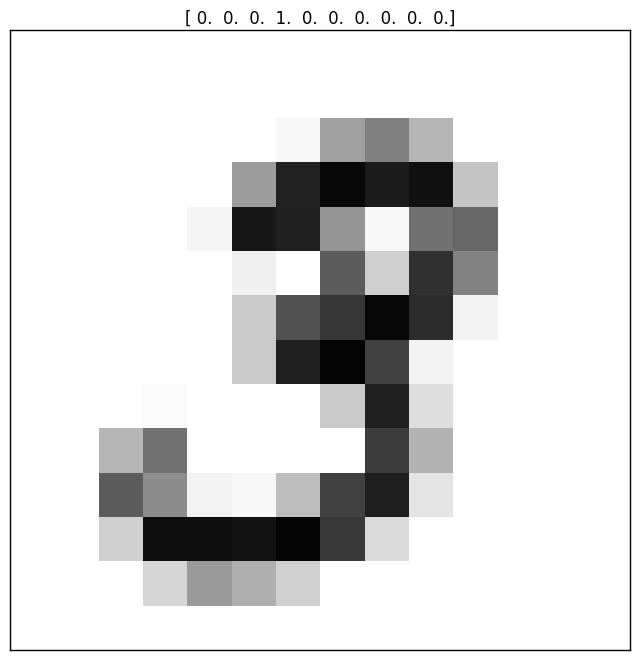

In [98]:
fig = plt.figure(figsize=(16,8))
plt.title(labels[1])
#plt.imshow(smaller(images[1]).reshape((14,14)), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off')
plt.imshow(smaller(images[1]).reshape((14,14)), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
print(np.argmax(labels[1]))

In [66]:
simage = smaller(images[1]).reshape(14,14)


In [65]:
simage.reshape(14,14)

0.030392158776521683

In [103]:
def plotInput(image, w, h, x, y):
    plt.subplot(w, h, y*w + x + 1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")


In [302]:
conv1 = Layer(3*3, 20) # 3x3の入力で20種類まで判定出来るたたみこみ層

In [303]:
def conv(conv, inp):
    (h, w) = inp.shape
    # convolution
    (cw, ch) = 3, 3
    (out_w, out_h) = w - (cw - 1), h - (ch - 1)
    out = np.zeros((out_h, out_w, 20))  # 縦12 x 横12 x 種20 の出力結果用
    for y in range(out_h):
        for x in range(out_w):
            window = inp[y:y+ch, x:x+cw].reshape(-1) # 窓を切り出して1次元配列にする
            out[y, x] = conv.output_layer(window)
            #print("y:" + str(y) + " x:" + str(x) + " data:" + str(window))
            #plotInput(inp[y:y+ch, x:x+cw], w, h, x, y)
    return out

def pooling(conv_out):
    (conv_out_h, conv_out_w, conv_out_z) = conv_out.shape
    # pooling 2x2 の範囲で最大のものを抽出
    (pw, ph) = 2, 2
    pooling = np.zeros((conv_out_h / ph, conv_out_w / pw, 20))  # 縦6 x 横6 x 種20 の出力結果用
    for y in range(0, conv_out_h, ph):
        for x in range(0, conv_out_w, pw):
            window = conv_out[y:y+ph, x:x+pw]
            # どの窓のどのパターンが一番反応したかを割り出す
            value = window.max()
            index = window.argmax()
            (window_y, window_x, z) = np.unravel_index(index, window.shape) # 配列が y, x, z 順の構造になってるの注意
            (max_y, max_x) = window_y + y, window_x + x
            pooling[y / ph, x / pw, z] = value # そのpoolingで最大のものを詰める
            #print("y:" + str(max_y) + " x:" + str(max_x) + " z:" + str(z) + " value:" + str(value))
    return pooling

def train_pooling(conv, inp, conv_out):
    (conv_out_h, conv_out_w, conv_out_z) = conv_out.shape
    # convolution
    (cw, ch) = 3, 3
    # pooling 2x2 の範囲で最大のものを抽出
    (pw, ph) = 2, 2
    for y in range(0, conv_out_h, ph):
        for x in range(0, conv_out_w, pw):
            window = conv_out[y:y+ph, x:x+pw]
            # どの窓のどのパターンが一番反応したかを割り出す
            value = window.max()
            index = window.argmax()
            (window_y, window_x, z) = np.unravel_index(index, window.shape) # 配列が y, x, z 順の構造になってるの注意
            (max_y, max_x) = window_y + y, window_x + x
            #print("y:" + str(max_y) + " x:" + str(max_x) + " z:" + str(z) + " value:" + str(value))
            # 最大のやつだけを「1」を出すよう訓練
            conv_inp = inp[max_y:max_y+ch, max_x:max_x+cw].reshape(-1)
            print("y:" + str(max_y) + " x:" + str(max_x) + " z:" + str(z) + " value:" + str(value))
            #conv.train_neuron(conv.w[z], conv.b[z], conv_inp, 1)
            t = np.zeros(20)
            t[z] = 1.0
            conv.train_layer(conv_inp, t)


In [304]:
alpha = 0.1

fig = plt.figure(figsize=(16,8))

def train_neocognitron(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        X = smaller(images[i]).reshape(14, 14)
        Y = conv(conv1, X)
        #print(pooling(Y))
        train_pooling(conv1, X, Y)


In [305]:
train_neocognitron(100)

y:0 x:0 z:3 value:0.52062006965
y:1 x:3 z:18 value:0.523796770093
y:1 x:4 z:7 value:0.541285469184
y:1 x:6 z:18 value:0.543946836276
y:0 x:8 z:7 value:0.525796385962
y:0 x:10 z:3 value:0.52062006965
y:2 x:0 z:3 value:0.52062006965
y:3 x:3 z:7 value:0.538452597439
y:2 x:4 z:7 value:0.548069207187
y:2 x:6 z:5 value:0.529531955886
y:2 x:8 z:3 value:0.528625085248
y:2 x:10 z:3 value:0.52062006965
y:4 x:0 z:3 value:0.52062006965
y:4 x:3 z:18 value:0.539121504388
y:4 x:4 z:18 value:0.549269544285
y:5 x:6 z:18 value:0.541459830286
y:5 x:8 z:7 value:0.525713762299
y:4 x:10 z:3 value:0.52062006965
y:6 x:0 z:3 value:0.52062006965
y:6 x:3 z:19 value:0.524248183546
y:6 x:5 z:5 value:0.529917558879
y:7 x:7 z:18 value:0.533323343131
y:7 x:8 z:7 value:0.538038187744
y:7 x:10 z:3 value:0.522300859341
y:8 x:0 z:3 value:0.52062006965
y:9 x:3 z:7 value:0.53177992678
y:9 x:5 z:18 value:0.540733396599
y:9 x:7 z:7 value:0.547172265199
y:8 x:8 z:18 value:0.543478795751
y:9 x:10 z:3 value:0.526668073281
y:10 

In [148]:
test_array = np.array([
        [ [ 1, 2, 3], [ 2, 4, 6], [ 7, 8, 9] ],
        [ [11,12,13], [12,14,16], [17,18,19] ],
        [ [21,22,23], [22,24,26], [27,28,29] ],
        [ [31,32,33], [32,34,36], [37,38,39] ]
    ])

In [149]:
test_array.shape

(4, 3, 3)

In [150]:
test_array.reshape(-1).shape

(36,)

In [53]:
getAreaInput(test_array, 0, 0, 2, 2)

height:4 width:3 depth:3
y:0 x:0 array:[1 2 3]
y:0 x:1 array:[2 4 6]
y:1 x:0 array:[11 12 13]
y:1 x:1 array:[12 14 16]
[  1.   2.   3.   2.   4.   6.  11.  12.  13.  12.  14.  16.]


In [28]:
test_array.reshape(1, -1)

array([[ 1,  2,  3,  2,  4,  6,  7,  8,  9, 11, 12, 13, 12, 14, 16, 17, 18,
        19, 21, 22, 23, 22, 24, 26, 27, 28, 29, 31, 32, 33, 32, 34, 36, 37,
        38, 39]])

In [54]:
test_array

array([[[ 1,  2,  3],
        [ 2,  4,  6],
        [ 7,  8,  9]],

       [[11, 12, 13],
        [12, 14, 16],
        [17, 18, 19]],

       [[21, 22, 23],
        [22, 24, 26],
        [27, 28, 29]],

       [[31, 32, 33],
        [32, 34, 36],
        [37, 38, 39]]])

In [14]:
test_array[0:1][1:2]

array([], shape=(0, 3, 3), dtype=int64)

In [15]:
test_array[0:1, 1:2]

array([[[2, 4, 6]]])

In [16]:
test_array

(4, 3, 3)

In [55]:
t2 = test_array[0:2, 1:3]

In [56]:
t2

array([[[ 2,  4,  6],
        [ 7,  8,  9]],

       [[12, 14, 16],
        [17, 18, 19]]])

In [57]:
t3 = test_array[0:2, 1:3]

In [58]:
t2[:]=t2*2

In [59]:
test_array

array([[[ 1,  2,  3],
        [ 4,  8, 12],
        [14, 16, 18]],

       [[11, 12, 13],
        [24, 28, 32],
        [34, 36, 38]],

       [[21, 22, 23],
        [22, 24, 26],
        [27, 28, 29]],

       [[31, 32, 33],
        [32, 34, 36],
        [37, 38, 39]]])

In [42]:
t2

array([[[ 4,  8, 12],
        [14, 16, 18]],

       [[24, 28, 32],
        [34, 36, 38]]])